## 0\. Motivação

Supondo que há o desejo de compra ou aquisição de um imóvel. Para isso, é preciso encontrar um modelo para que seja possivel, por meio de variáveis bem delimitadas, encontrar o valor de acordo com variáveis diversas desde caracteristicas do imóvel até o IDH da região.

## 1\. Coleta de dados

### 1\.1. Pacotes e Bibliotecas

In [2]:
import os
import re

import requests
from requests.exceptions import HTTPError
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
import numpy as np
import geopandas
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

### 1\.2. Web Scraping

Primeiro será feita a coleta de dados pelo scraping, pois a base de dados está em HTML no site em questão. Os valores são referentes ao mês de Março de 2023.

In [3]:
# URL do site que você deseja verificar
url = 'https://www.agenteimovel.com.br/mercado-imobiliario/a-venda/sp/sao-paulo/'

# Fazendo a requisição GET ao site
response = requests.get(url)

# Verificando o código de status da resposta
status_code = response.status_code

# Verificando se ocorreu um erro
if status_code >= 400:
    print(f"Ocorreu um erro ao acessar a URL. Código de status: {status_code}")
else:
    print("A requisição foi bem-sucedida. O site está disponível.")

A requisição foi bem-sucedida. O site está disponível.


In [4]:
def crawl_website(url: str) -> str:

  try:
    resposta = requests.get(url)
    resposta.raise_for_status()
  except HTTPError as exc:
    print(exc)
  else:
    return resposta.text

URL = 'https://www.agenteimovel.com.br/mercado-imobiliario/a-venda/sp/sao-paulo/'

robots = crawl_website(url=URL)

if  re.findall('ranking', robots, re.IGNORECASE) == True or re.findall('project', robots, re.IGNORECASE) == False:
  print(True) 
else:
  print(False) 

False


In [5]:
URL = 'https://www.agenteimovel.com.br/mercado-imobiliario/a-venda/sp/sao-paulo/'
conteudo = crawl_website(url=URL)

pagina = BeautifulSoup(conteudo, 'html.parser')
tabela = pagina.find('table', {'class': 'bairro'}).text.split('\n\n\n')

In [6]:
dados = []
for linha in tabela:
    teste = linha.split('\n')
    dados.append(teste)

In [7]:
resultado = [[value.replace('R$', '').replace('%', '').replace('-','').replace('+','').replace('.','').strip() for value in linha if value] for linha in dados]
preco_m2_df = pd.DataFrame(resultado[1:], columns=resultado[0])
preco_m2_df = preco_m2_df[['Bairro','Preço/M²']].rename(columns={'Bairro':'district','Preço/M²':'price_per_m2'})

preco_m2_df['price_per_m2'] = preco_m2_df['price_per_m2'].astype('Int64')

preco_m2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   district      550 non-null    object
 1   price_per_m2  550 non-null    Int64 
dtypes: Int64(1), object(1)
memory usage: 9.3+ KB


Esse outro dataset foi retirado do Kaggle. Tal dataset tem como base os valores dos aluguéis disponiveis pelo Quinto Andar, um site de aluguéis de imóveis bem famoso. A data referência é a de Maio de 2023, apenas 2 meses a mais do que a outra base de dados anteriormente coletada.
 
Link: https://www.kaggle.com/datasets/renatosn/sao-paulo-housing-prices

In [8]:
# Leitura dos dados de locações em SP
sp_df = pd.read_csv('saopaulo_precos.csv')
sp_df

,address,district,area,bedrooms,garage,type,rent,total
0,Rua Herval,Belenzinho,21,1,0,Studio e kitnet,2400,2939
1,Avenida São Miguel,Vila Marieta,15,1,1,Studio e kitnet,1030,1345
2,Rua Oscar Freire,Pinheiros,18,1,0,Apartamento,4000,4661
3,Rua Júlio Sayago,Vila Ré,56,2,2,Casa em condomínio,1750,1954
4,Rua Barata Ribeiro,Bela Vista,19,1,0,Studio e kitnet,4000,4654
...,...,...,...,...,...,...,...,...
11652,Avenida Adolfo Pinheiro,Santo Amaro,94,2,1,Apartamento,4100,5778
11653,Rua Professor Alexandre Correia,Jardim Vitória Régia,350,4,4,Apartamento,11250,17480
11654,Rua Abílio Borin,Jardim Caravelas,84,1,2,Apartamento,4500,5467
11655,Rua Forte William,Jardim Fonte do Morumbi,76,1,0,Apartamento,9000,10200


In [9]:
sp_df = pd.merge(left=sp_df,right=preco_m2_df)
sp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9048 entries, 0 to 9047
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   address       9048 non-null   object
 1   district      9048 non-null   object
 2   area          9048 non-null   int64 
 3   bedrooms      9048 non-null   int64 
 4   garage        9048 non-null   int64 
 5   type          9048 non-null   object
 6   rent          9048 non-null   int64 
 7   total         9048 non-null   int64 
 8   price_per_m2  9048 non-null   Int64 
dtypes: Int64(1), int64(5), object(3)
memory usage: 645.1+ KB


In [10]:

sp_df['valor_estimado_area'] = sp_df['area']*sp_df['price_per_m2']
sp_df

,address,district,area,bedrooms,garage,type,rent,total,price_per_m2,valor_estimado_area
0,Rua Herval,Belenzinho,21,1,0,Studio e kitnet,2400,2939,8184,171864
1,Avenida Celso Garcia,Belenzinho,44,2,1,Apartamento,1850,2321,8184,360096
2,Rua Herval,Belenzinho,40,1,0,Apartamento,1800,2069,8184,327360
3,Rua Herval,Belenzinho,30,1,0,Apartamento,1800,2069,8184,245520
4,Rua Serra da Mantiqueira,Belenzinho,100,3,0,Casa,3850,4113,8184,818400
...,...,...,...,...,...,...,...,...,...,...
9043,Rua João Teizen Sobrinho,Jardim Santa Helena,310,4,4,Casa,10000,11390,4852,1504120
9044,Rua Edmundo Amaral Valente,Parque Munhoz,56,2,2,Apartamento,1500,2188,5125,287000
9045,"Parque do Morumbi, São Paulo - Sp, 05706-290, ...",Parque do Morumbi,140,3,2,Apartamento,3000,4399,10357,1449980
9046,Avenida Dona Helena Pereira de Moraes,Parque do Morumbi,220,2,0,Apartamento,11250,16620,10357,2278540


Aqui eu retirei a lista dos bairros existentes em São Paulo, para delimitar apenas os endereços na cidade.

In [11]:
bairros2 = []

URL3 = 'https://pt.wikipedia.org/wiki/Lista_dos_distritos_de_S%C3%A3o_Paulo_por_popula%C3%A7%C3%A3o'
conteudo3 = crawl_website(url=URL3)

pagina3 = BeautifulSoup(conteudo3, 'html.parser')

tabela3 = pagina3.find_all('div', {'style': 'padding:0em 0.25em'})[2].text
tabela3 = tabela3.split('\n')

for bairro in tabela3:
    if bairro != '':
        bairros2.append(bairro)

print(len(bairros2))


96


In [12]:
df = sp_df[sp_df['district'].isin(bairros2)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3701 entries, 37 to 9018
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   address              3701 non-null   object
 1   district             3701 non-null   object
 2   area                 3701 non-null   int64 
 3   bedrooms             3701 non-null   int64 
 4   garage               3701 non-null   int64 
 5   type                 3701 non-null   object
 6   rent                 3701 non-null   int64 
 7   total                3701 non-null   int64 
 8   price_per_m2         3701 non-null   Int64 
 9   valor_estimado_area  3701 non-null   Int64 
dtypes: Int64(2), int64(5), object(3)
memory usage: 325.3+ KB


## 2\. Preparação dos dados

### 2\.1. Geocodificação

O intuito aqui é gerar os dados de geolocalização para posteriormente gerar o mapa dos imóveis da cidade de São Paulo com esses valores.

In [16]:
# Geocodificação dos endereços
geolocator = Nominatim(user_agent="caiombr", timeout=5)
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

In [17]:
df['location'] = df['address'] + ', ' + df['district'] + ', São Paulo, SP' # Concatena o endereço com a cidade e estado

df['coordinates'] = df['location'].apply(geocode).apply(lambda x: (x.latitude, x.longitude) if x else None)


C:\Users\caiom\AppData\Local\Temp\ipykernel_9568\3737962230.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['location'] = df['address'] + ', ' + df['district'] + ', São Paulo, SP' # Concatena o endereço com a cidade e estado
C:\Users\caiom\AppData\Local\Temp\ipykernel_9568\3737962230.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['coordinates'] = df['location'].apply(geocode).apply(lambda x: (x.latitude, x.longitude) if x else None)


In [19]:
df.to_csv('dataframe_backup.csv')

### 2\.2. Tratamento Pandas

Eu gerei o arquivo em CSV para não ter que fazer a leitura do arquivo toda vez que eu for trabalhar no projeto

In [54]:
data = pd.read_csv('dataframe.csv')
data = data.drop(['Unnamed: 0','address','location'], axis=1)

data.head()

,district,area,bedrooms,garage,type,rent,total,price_per_m2,valor_estimado_area,coordinates
0,Pinheiros,18,1,0,Apartamento,4000,4661,15337,276066,"(-23.5507897, -46.6787724)"
1,Pinheiros,19,1,0,Studio e kitnet,3400,3905,15337,291403,"(-23.5507897, -46.6787724)"
2,Pinheiros,34,1,1,Studio e kitnet,3231,4083,15337,521458,"(-23.566351, -46.6856195)"
3,Pinheiros,33,1,0,Studio e kitnet,3417,4018,15337,506121,"(-23.5501258, -46.6822123)"
4,Pinheiros,34,1,1,Apartamento,4850,5677,15337,521458,"(-23.5703061, -46.7001637)"


In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3701 entries, 0 to 3700
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   district             3701 non-null   object
 1   area                 3701 non-null   int64 
 2   bedrooms             3701 non-null   int64 
 3   garage               3701 non-null   int64 
 4   type                 3701 non-null   object
 5   rent                 3701 non-null   int64 
 6   total                3701 non-null   int64 
 7   price_per_m2         3701 non-null   int64 
 8   valor_estimado_area  3701 non-null   int64 
 9   coordinates          3303 non-null   object
dtypes: int64(7), object(3)
memory usage: 289.3+ KB


In [56]:
# Limpeza dos dados nulos
data = data.dropna()
data.head()

,district,area,bedrooms,garage,type,rent,total,price_per_m2,valor_estimado_area,coordinates
0,Pinheiros,18,1,0,Apartamento,4000,4661,15337,276066,"(-23.5507897, -46.6787724)"
1,Pinheiros,19,1,0,Studio e kitnet,3400,3905,15337,291403,"(-23.5507897, -46.6787724)"
2,Pinheiros,34,1,1,Studio e kitnet,3231,4083,15337,521458,"(-23.566351, -46.6856195)"
3,Pinheiros,33,1,0,Studio e kitnet,3417,4018,15337,506121,"(-23.5501258, -46.6822123)"
4,Pinheiros,34,1,1,Apartamento,4850,5677,15337,521458,"(-23.5703061, -46.7001637)"


In [57]:
data['another_costs'] = data['total'] - data['rent'] 
data = data.drop('total',axis=1)
data.head()

,district,area,bedrooms,garage,type,rent,price_per_m2,valor_estimado_area,coordinates,another_costs
0,Pinheiros,18,1,0,Apartamento,4000,15337,276066,"(-23.5507897, -46.6787724)",661
1,Pinheiros,19,1,0,Studio e kitnet,3400,15337,291403,"(-23.5507897, -46.6787724)",505
2,Pinheiros,34,1,1,Studio e kitnet,3231,15337,521458,"(-23.566351, -46.6856195)",852
3,Pinheiros,33,1,0,Studio e kitnet,3417,15337,506121,"(-23.5501258, -46.6822123)",601
4,Pinheiros,34,1,1,Apartamento,4850,15337,521458,"(-23.5703061, -46.7001637)",827


Para melhorar a qualidade da modelagem, eu criei um arquivo xlsx para trazer mais dados importantes sobre as regiões dos imóveis. A fonte primária dos dados é a: https://www.redesocialdecidades.org.br/, fonte do governo de São Paulo.

In [58]:
variaveis_sp_df = pd.read_excel('variaveis_sp.xls')
variaveis_sp_df

,district,subprefeitura,exp_de_vida_media,area_verde_m2_por_pop,centros_culturais,num_salas_teatro,IDH,homicidios_inv,roubos_invertidos,leitos_hospitalares,media_desemprego_inv
0,Aricanduva,Aricanduva/Formosa/Carrão,70.51,4.099684,0.555196,0,0.885,-2.36,-2490,6,-9.0
1,Carrão,Aricanduva/Formosa/Carrão,73.75,4.099684,0.219172,1,0.886,-10.65,-2490,6,-9.0
2,Vila Formosa,Aricanduva/Formosa/Carrão,72.65,4.099684,3.090354,3,0.884,-1.07,-2490,0,-9.0
3,Butantã,Butantã,74.38,5.645112,0.032341,2,0.928,-1.86,-4314,0,-6.8
4,Morumbi,Butantã,73.48,5.645112,0.077570,1,0.938,-3.63,-4314,0,-6.8
...,...,...,...,...,...,...,...,...,...,...,...
91,Moema,Vila Mariana,80.57,2.835862,0.000000,3,0.961,-1.12,-6254,2464,-8.4
92,Saúde,Vila Mariana,77.16,2.835862,0.222869,2,0.942,-2.94,-6254,125,-8.4
93,Vila Mariana,Vila Mariana,78.17,2.835862,0.379061,10,0.950,-2.28,-6254,5,-8.4
94,São Lucas,Vila Prudente,71.42,1.603757,0.064481,0,0.847,-4.26,-3230,170,-9.0


In [59]:
data = pd.merge(left=data,right=variaveis_sp_df)

data.head()

,district,area,bedrooms,garage,type,rent,price_per_m2,valor_estimado_area,coordinates,another_costs,subprefeitura,exp_de_vida_media,area_verde_m2_por_pop,centros_culturais,num_salas_teatro,IDH,homicidios_inv,roubos_invertidos,leitos_hospitalares,media_desemprego_inv
0,Pinheiros,18,1,0,Apartamento,4000,15337,276066,"(-23.5507897, -46.6787724)",661,Pinheiros,78.05,6.326603,0.544101,14,0.96,-3.06,-7811,231,-6.8
1,Pinheiros,19,1,0,Studio e kitnet,3400,15337,291403,"(-23.5507897, -46.6787724)",505,Pinheiros,78.05,6.326603,0.544101,14,0.96,-3.06,-7811,231,-6.8
2,Pinheiros,34,1,1,Studio e kitnet,3231,15337,521458,"(-23.566351, -46.6856195)",852,Pinheiros,78.05,6.326603,0.544101,14,0.96,-3.06,-7811,231,-6.8
3,Pinheiros,33,1,0,Studio e kitnet,3417,15337,506121,"(-23.5501258, -46.6822123)",601,Pinheiros,78.05,6.326603,0.544101,14,0.96,-3.06,-7811,231,-6.8
4,Pinheiros,34,1,1,Apartamento,4850,15337,521458,"(-23.5703061, -46.7001637)",827,Pinheiros,78.05,6.326603,0.544101,14,0.96,-3.06,-7811,231,-6.8


Preciso transformar as coordenadas em latitude e longitude, para posteriormente facilitar o processamento da plotagem focada apenas na capital de SP.

In [60]:
data[['latitude', 'longitude']] = data['coordinates'].str.strip('()').str.split(', ', expand=True)
data['latitude'] = data['latitude'].astype(float)
data['longitude'] = data['longitude'].astype(float)

# data_filtro = data.loc[(data['longitude'] >= -47) & (data['longitude'] <= -46.3)]
data_filtro = data.loc[(data['longitude'] >= -46.77) & (data['longitude'] <= -46.3)]
data_filtro = data_filtro.loc[(data['latitude'] >= -24) & (data['latitude'] <= -23)]
data = data_filtro.drop('coordinates',axis=1)


# data['latitude'] = data['latitude'].astype(str)
# data['longitude'] = data['longitude'].astype(str)

In [61]:
data.head()

,district,area,bedrooms,garage,type,rent,price_per_m2,valor_estimado_area,another_costs,subprefeitura,...,area_verde_m2_por_pop,centros_culturais,num_salas_teatro,IDH,homicidios_inv,roubos_invertidos,leitos_hospitalares,media_desemprego_inv,latitude,longitude
0,Pinheiros,18,1,0,Apartamento,4000,15337,276066,661,Pinheiros,...,6.326603,0.544101,14,0.96,-3.06,-7811,231,-6.8,-23.550790,-46.678772
1,Pinheiros,19,1,0,Studio e kitnet,3400,15337,291403,505,Pinheiros,...,6.326603,0.544101,14,0.96,-3.06,-7811,231,-6.8,-23.550790,-46.678772
2,Pinheiros,34,1,1,Studio e kitnet,3231,15337,521458,852,Pinheiros,...,6.326603,0.544101,14,0.96,-3.06,-7811,231,-6.8,-23.566351,-46.685620
3,Pinheiros,33,1,0,Studio e kitnet,3417,15337,506121,601,Pinheiros,...,6.326603,0.544101,14,0.96,-3.06,-7811,231,-6.8,-23.550126,-46.682212
4,Pinheiros,34,1,1,Apartamento,4850,15337,521458,827,Pinheiros,...,6.326603,0.544101,14,0.96,-3.06,-7811,231,-6.8,-23.570306,-46.700164


Vou gerar um arquivo CSV para posterior visualização no Power BI

In [67]:
data_bi = data[["district","area","bedrooms","type","rent","another_costs","valor_estimado_area","latitude","longitude"]]
data_bi["aluguel_e_despesas"] = data_bi["rent"] + data_bi["another_costs"]
data_bi = data_bi[["district","area","bedrooms","type","aluguel_e_despesas","valor_estimado_area","latitude","longitude"]]

data_bi.to_excel('data_bi.xlsx',index=None)

C:\Users\caiom\AppData\Local\Temp\ipykernel_5960\1146682852.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_bi["aluguel_e_despesas"] = data_bi["rent"] + data_bi["another_costs"]


### 2\.3. Testes do Dataframe

In [12]:
teste = data[['district','subprefeitura','type','rent','another_costs','valor_estimado_area']]
teste['contagem'] = 1


C:\Users\caiom\AppData\Local\Temp\ipykernel_5960\726145058.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teste['contagem'] = 1


In [13]:
teste.sort_values('rent',ascending=0).head()

,district,subprefeitura,type,rent,another_costs,valor_estimado_area,contagem
1691,Consolação,Sé,Apartamento,15000,4590,3054960,1
3106,Alto de Pinheiros,Pinheiros,Casa,15000,6050,4188100,1
2353,Santo Amaro,Santo Amaro,Casa,15000,4750,4669650,1
2354,Santo Amaro,Santo Amaro,Apartamento,15000,9270,3414033,1
2356,Santo Amaro,Santo Amaro,Apartamento,15000,11550,3414033,1


In [201]:
teste.sort_values('valor_estimado_area',ascending=0).head()

,district,subprefeitura,type,rent,another_costs,valor_estimado_area,contagem
1821,Campo Belo,Santo Amaro,Casa,10000,200,6845700,1
2717,Jardim Paulista,Pinheiros,Apartamento,8000,4640,6020377,1
1847,Campo Belo,Santo Amaro,Casa,14000,2590,6005000,1
1849,Campo Belo,Santo Amaro,Casa,8430,1780,5980980,1
1848,Campo Belo,Santo Amaro,Casa,11250,3810,5788820,1


In [202]:
teste_type = teste[['type','contagem']].groupby('type').count().reset_index().sort_values('contagem',ascending=0)
teste_type

,type,contagem
0,Apartamento,2263
3,Studio e kitnet,560
1,Casa,420
2,Casa em condomínio,32


In [203]:
teste_district = teste[['district','contagem']].groupby('district').count().reset_index().sort_values('contagem',ascending=0)
teste_district.head(5)

,district,contagem
2,Bela Vista,272
21,Jardim Paulista,219
54,Vila Mariana,210
33,Pinheiros,155
39,Santana,151


In [204]:
teste_district = teste[['subprefeitura','contagem']].groupby('subprefeitura').count().reset_index().sort_values('contagem',ascending=0)
teste_district.head(5)

,subprefeitura,contagem
21,Sé,852
16,Pinheiros,443
14,Mooca,359
23,Vila Mariana,261
12,Lapa,233


## 3\. Modelagem dos dados

### 3\.1. Organização

Agora será feito a modelagem dos dados para o processo de aprendizagem de maquina.

In [10]:
data_1 = data.drop(['latitude','longitude'],axis=1)


data_1.head()

,district,area,bedrooms,garage,type,rent,price_per_m2,valor_estimado_area,another_costs,subprefeitura,exp_de_vida_media,area_verde_m2_por_pop,centros_culturais,num_salas_teatro,IDH,homicidios_inv,roubos_invertidos,leitos_hospitalares,media_desemprego_inv
0,Pinheiros,18,1,0,Apartamento,4000,15337,276066,661,Pinheiros,78.05,6.326603,0.544101,14,0.96,-3.06,-7811,231,-6.8
1,Pinheiros,19,1,0,Studio e kitnet,3400,15337,291403,505,Pinheiros,78.05,6.326603,0.544101,14,0.96,-3.06,-7811,231,-6.8
2,Pinheiros,34,1,1,Studio e kitnet,3231,15337,521458,852,Pinheiros,78.05,6.326603,0.544101,14,0.96,-3.06,-7811,231,-6.8
3,Pinheiros,33,1,0,Studio e kitnet,3417,15337,506121,601,Pinheiros,78.05,6.326603,0.544101,14,0.96,-3.06,-7811,231,-6.8
4,Pinheiros,34,1,1,Apartamento,4850,15337,521458,827,Pinheiros,78.05,6.326603,0.544101,14,0.96,-3.06,-7811,231,-6.8


In [11]:
# Padronização das variáveis numéricas

columns_to_standardize = ['area','bedrooms','garage','price_per_m2','rent','another_costs','exp_de_vida_media','area_verde_m2_por_pop'
                          ,'centros_culturais','num_salas_teatro','IDH','homicidios_inv','roubos_invertidos','leitos_hospitalares','media_desemprego_inv']

scaler = StandardScaler()

media = []
desvio_padrão = []

for column in columns_to_standardize:
    scaler.fit(data[[column]])
    data_1[column + '_std'] = scaler.transform(data[[column]])


In [12]:
data_1.head()

,district,area,bedrooms,garage,type,rent,price_per_m2,valor_estimado_area,another_costs,subprefeitura,...,another_costs_std,exp_de_vida_media_std,area_verde_m2_por_pop_std,centros_culturais_std,num_salas_teatro_std,IDH_std,homicidios_inv_std,roubos_invertidos_std,leitos_hospitalares_std,media_desemprego_inv_std
0,Pinheiros,18,1,0,Apartamento,4000,15337,276066,661,Pinheiros,...,-0.328609,0.851669,0.106179,-0.027978,0.234195,1.101196,0.384787,-0.135585,-0.025313,0.919899
1,Pinheiros,19,1,0,Studio e kitnet,3400,15337,291403,505,Pinheiros,...,-0.478100,0.851669,0.106179,-0.027978,0.234195,1.101196,0.384787,-0.135585,-0.025313,0.919899
2,Pinheiros,34,1,1,Studio e kitnet,3231,15337,521458,852,Pinheiros,...,-0.145578,0.851669,0.106179,-0.027978,0.234195,1.101196,0.384787,-0.135585,-0.025313,0.919899
3,Pinheiros,33,1,0,Studio e kitnet,3417,15337,506121,601,Pinheiros,...,-0.386105,0.851669,0.106179,-0.027978,0.234195,1.101196,0.384787,-0.135585,-0.025313,0.919899
4,Pinheiros,34,1,1,Apartamento,4850,15337,521458,827,Pinheiros,...,-0.169535,0.851669,0.106179,-0.027978,0.234195,1.101196,0.384787,-0.135585,-0.025313,0.919899


In [13]:
# variáveis categóricas

columns_categorical = ['district','type','subprefeitura']

for column in columns_categorical:

    data_1[column].drop_duplicates
    data_1_ord = dict(zip(data_1[column].unique(), range(len(data_1[column].unique()))))
    data_1[column + '_ord'] = data_1[column].apply(lambda x: data_1_ord[x])

In [14]:
data_1.head()

,district,area,bedrooms,garage,type,rent,price_per_m2,valor_estimado_area,another_costs,subprefeitura,...,centros_culturais_std,num_salas_teatro_std,IDH_std,homicidios_inv_std,roubos_invertidos_std,leitos_hospitalares_std,media_desemprego_inv_std,district_ord,type_ord,subprefeitura_ord
0,Pinheiros,18,1,0,Apartamento,4000,15337,276066,661,Pinheiros,...,-0.027978,0.234195,1.101196,0.384787,-0.135585,-0.025313,0.919899,0,0,0
1,Pinheiros,19,1,0,Studio e kitnet,3400,15337,291403,505,Pinheiros,...,-0.027978,0.234195,1.101196,0.384787,-0.135585,-0.025313,0.919899,0,1,0
2,Pinheiros,34,1,1,Studio e kitnet,3231,15337,521458,852,Pinheiros,...,-0.027978,0.234195,1.101196,0.384787,-0.135585,-0.025313,0.919899,0,1,0
3,Pinheiros,33,1,0,Studio e kitnet,3417,15337,506121,601,Pinheiros,...,-0.027978,0.234195,1.101196,0.384787,-0.135585,-0.025313,0.919899,0,1,0
4,Pinheiros,34,1,1,Apartamento,4850,15337,521458,827,Pinheiros,...,-0.027978,0.234195,1.101196,0.384787,-0.135585,-0.025313,0.919899,0,0,0


In [16]:
data_1[['type','type_ord']].drop_duplicates('type_ord')

,type,type_ord
0,Apartamento,0
1,Studio e kitnet,1
11,Casa,2
116,Casa em condomínio,3


In [17]:
data_1[['district','district_ord']].drop_duplicates('district_ord')

,district,district_ord
0,Pinheiros,0
155,Bela Vista,1
441,Brás,2
568,Sé,3
628,Tatuapé,4
721,Cambuci,5
813,Liberdade,6
911,Mooca,7
1032,Saúde,8
1053,Vila Medeiros,9


In [19]:
data_1[['subprefeitura','subprefeitura_ord']].drop_duplicates('subprefeitura_ord')

,subprefeitura,subprefeitura_ord
0,Pinheiros,0
155,Sé,1
441,Mooca,2
1032,Vila Mariana,3
1053,Vila Maria/Vila Guilherme,4
1078,Lapa,5
1107,Vila Prudente,6
1192,Campo Limpo,7
1472,Ipiranga,8
1731,Jaçanã/Tremembé,9


In [20]:
for column in columns_to_standardize:
    data_1 = data_1.drop(column,axis=1)

for column in columns_categorical:
    data_1 = data_1.drop(column,axis=1)

In [21]:
data_1.head()

,valor_estimado_area,area_std,bedrooms_std,garage_std,price_per_m2_std,rent_std,another_costs_std,exp_de_vida_media_std,area_verde_m2_por_pop_std,centros_culturais_std,num_salas_teatro_std,IDH_std,homicidios_inv_std,roubos_invertidos_std,leitos_hospitalares_std,media_desemprego_inv_std,district_ord,type_ord,subprefeitura_ord
0,276066,-0.882182,-0.913178,-0.895405,1.699474,0.157912,-0.328609,0.851669,0.106179,-0.027978,0.234195,1.101196,0.384787,-0.135585,-0.025313,0.919899,0,0,0
1,291403,-0.867525,-0.913178,-0.895405,1.699474,-0.064101,-0.478100,0.851669,0.106179,-0.027978,0.234195,1.101196,0.384787,-0.135585,-0.025313,0.919899,0,1,0
2,521458,-0.647660,-0.913178,0.095958,1.699474,-0.126635,-0.145578,0.851669,0.106179,-0.027978,0.234195,1.101196,0.384787,-0.135585,-0.025313,0.919899,0,1,0
3,506121,-0.662318,-0.913178,-0.895405,1.699474,-0.057811,-0.386105,0.851669,0.106179,-0.027978,0.234195,1.101196,0.384787,-0.135585,-0.025313,0.919899,0,1,0
4,521458,-0.647660,-0.913178,0.095958,1.699474,0.472431,-0.169535,0.851669,0.106179,-0.027978,0.234195,1.101196,0.384787,-0.135585,-0.025313,0.919899,0,0,0


In [22]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3275 entries, 0 to 3302
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   valor_estimado_area        3275 non-null   int64  
 1   area_std                   3275 non-null   float64
 2   bedrooms_std               3275 non-null   float64
 3   garage_std                 3275 non-null   float64
 4   price_per_m2_std           3275 non-null   float64
 5   rent_std                   3275 non-null   float64
 6   another_costs_std          3275 non-null   float64
 7   exp_de_vida_media_std      3275 non-null   float64
 8   area_verde_m2_por_pop_std  3275 non-null   float64
 9   centros_culturais_std      3275 non-null   float64
 10  num_salas_teatro_std       3275 non-null   float64
 11  IDH_std                    3275 non-null   float64
 12  homicidios_inv_std         3275 non-null   float64
 13  roubos_invertidos_std      3275 non-null   float64
 1

In [239]:
data_1.to_excel('data_1.xlsx')

### 3\.2. Treino e Teste

In [23]:
predictors_train, predictors_test, target_train, target_test = train_test_split(
    data_1.drop(['valor_estimado_area'], axis=1), 
    data_1['valor_estimado_area'], 
    test_size=0.33, 
    random_state=123
)

In [24]:
predictors_train.head()

,area_std,bedrooms_std,garage_std,price_per_m2_std,rent_std,another_costs_std,exp_de_vida_media_std,area_verde_m2_por_pop_std,centros_culturais_std,num_salas_teatro_std,IDH_std,homicidios_inv_std,roubos_invertidos_std,leitos_hospitalares_std,media_desemprego_inv_std,district_ord,type_ord,subprefeitura_ord
1770,2.664959,2.336359,5.052771,-1.009618,2.285540,-0.387063,0.059267,2.472185,2.727506,-0.783446,-0.570581,0.957896,1.142522,-0.056022,-1.214158,20,2,10
3087,-0.149302,0.170001,1.087320,2.034590,0.620440,2.026833,1.375777,-0.372275,-0.616789,-0.626886,1.125781,0.748131,0.294968,4.872891,-0.181550,40,0,3
3123,-0.706291,-0.913178,-0.895405,-1.190779,-0.509978,-0.341066,-1.184450,-0.414636,-0.568465,-0.548606,-1.676904,-0.019761,-1.512964,0.729270,0.851058,42,1,1
381,-0.589030,-0.913178,-0.895405,-0.011952,-0.860389,-0.494390,-0.186148,-0.414636,-0.015972,2.426036,0.609497,0.435355,-1.512964,-0.532023,0.851058,1,0,1
221,-0.530400,-0.913178,-0.895405,-0.011952,-0.767143,-0.620883,-0.186148,-0.414636,-0.015972,2.426036,0.609497,0.435355,-1.512964,-0.532023,0.851058,1,1,1


In [25]:
target_train.head()

1770    1786980
3087    1114112
3123     189210
381      379620
221      419580
Name: valor_estimado_area, dtype: int64

In [26]:
target_test.head()

3260    134725
620     301960
3295    295680
310     499500
1636    572805
Name: valor_estimado_area, dtype: int64

### 3\.3. Regressão Linear

In [27]:
model = LinearRegression()

model = model.fit(predictors_train, target_train)

model.__dict__

{'fit_intercept': True,
 'copy_X': True,
 'n_jobs': None,
 'positive': False,
 'feature_names_in_': array(['area_std', 'bedrooms_std', 'garage_std', 'price_per_m2_std',
        'rent_std', 'another_costs_std', 'exp_de_vida_media_std',
        'area_verde_m2_por_pop_std', 'centros_culturais_std',
        'num_salas_teatro_std', 'IDH_std', 'homicidios_inv_std',
        'roubos_invertidos_std', 'leitos_hospitalares_std',
        'media_desemprego_inv_std', 'district_ord', 'type_ord',
        'subprefeitura_ord'], dtype=object),
 'n_features_in_': 18,
 'coef_': array([662060.79233204,  22422.2464435 , -62645.58780373, 240360.6808289 ,
         24568.42397323,  77782.02864602,  20986.53776905,  -4549.17912677,
         13631.11653741, -26077.69819121, -20208.29909392, -20957.65476914,
        -45121.79415468,   2813.62032775, -12707.47139749,    988.11108066,
        -10935.49322861,   -741.94940575]),
 'rank_': 18,
 'singular_': array([638.15617889, 206.98464491,  88.23713018,  70.67896428

In [28]:
a = model.coef_
print(a)

b = model.intercept_
print(b)

[662060.79233204  22422.2464435  -62645.58780373 240360.6808289
  24568.42397323  77782.02864602  20986.53776905  -4549.17912677
  13631.11653741 -26077.69819121 -20208.29909392 -20957.65476914
 -45121.79415468   2813.62032775 -12707.47139749    988.11108066
 -10935.49322861   -741.94940575]
784891.3574995317


In [29]:
target_predicted = model.predict(predictors_test)
target_predicted[0:5]


array([-110205.32548976,  295156.32093257,  209311.4561211 ,
        467189.34453322,  697247.96789567])

Fazendo o cálculo do RMSE, foi descoberto uma diferença de 21,36% da média.

In [30]:
rmse = np.sqrt(mean_squared_error(target_test, target_predicted))
print(rmse)

proporcao = round((rmse / data_1['valor_estimado_area'].mean()) * 100,2)
print(f'{proporcao} %')

169886.1384598395
21.36 %


## 4\. Visualização

Gerei um mapa mostrando a dispersão dos imóveis pela cidade de São Paulo.

In [31]:
mapa = geopandas.read_file("./DISTRITO_MUNICIPAL_SP_SMDU/DISTRITO_MUNICIPAL_SP_SMDUPolygon.shp")

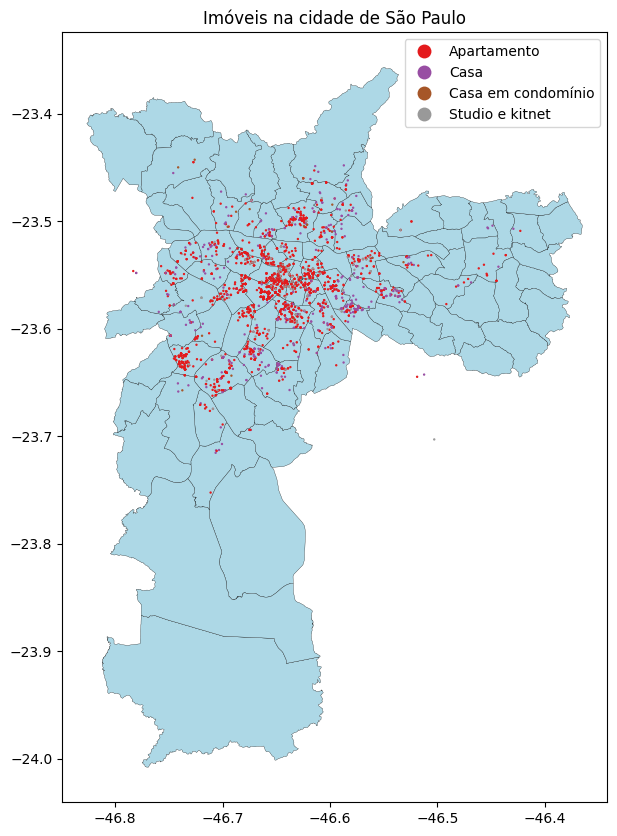

In [32]:
geo_df = geopandas.GeoDataFrame(data, geometry=geopandas.points_from_xy(data['longitude'], data['latitude']))

fig, ax = plt.subplots(figsize=(10, 10))

mapa.plot(ax=ax,alpha=1,color='lightblue',linewidth=0.2, edgecolor='black')

geo_df.plot(ax=ax, markersize=0.5,categorical=True, column='type', legend=True, legend_kwds={'bbox_to_anchor': (1, 1)}, cmap='Set1')
plt.title('Imóveis na cidade de São Paulo')

plt.show()

E gerei também um gráfico mostrando a comparação entre os valores teste e o modelo apresentado.

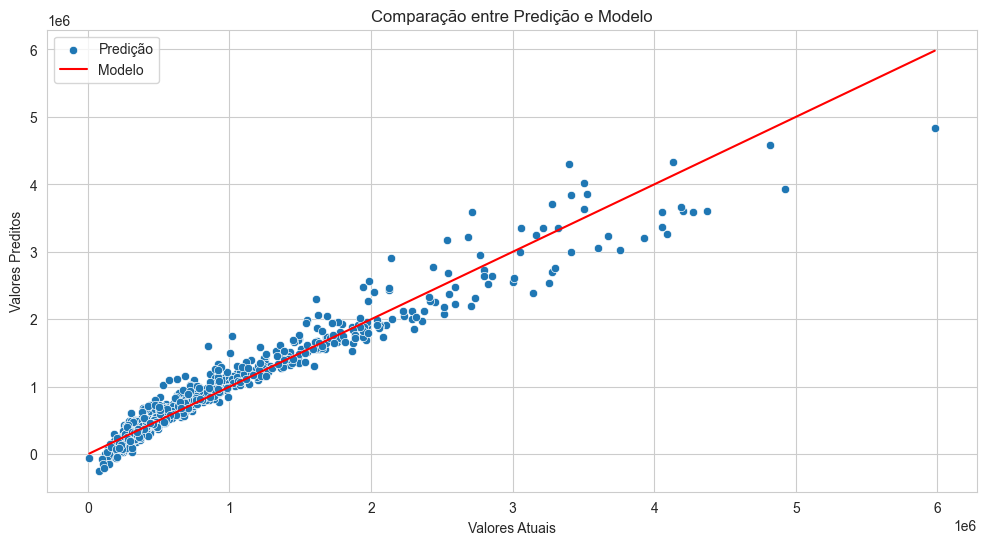

In [33]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=target_test, y=target_predicted, label='Predição')
    sns.lineplot(x=target_test, y=target_test, color='red', label='Modelo')
    plt.xlabel('Valores Atuais')
    plt.ylabel('Valores Preditos')
    plt.legend()
    plt.title('Comparação entre Predição e Modelo')
    plt.show()


## 5\. Resultado

Usarei um exemplo criado para verificar a acurácia do modelo em relação ao encontro do valor do imóvel. Um apartamento em Pinheiros com 36m² (as outras variáveis, eu optei por inserir um valor médio desejado e que mantenha um padrão bom de qualidade)

In [49]:
exemplo = [36,2,1,12000,3500,500,80,12,2,1,0.95,-1,-1000,1000,-6]
exemplo_ord = [11,0,6]

In [50]:
exemplo_padronizado = []

i = 0

for coluna in columns_to_standardize:
   mean = data[coluna].mean()
   std = data[coluna].std()
   valor = (exemplo[i] - mean) / std
   exemplo_padronizado.append(valor)
   i +=1


In [51]:
for x in exemplo_ord:
    exemplo_padronizado.append(x)

In [53]:
exemplo_padronizado = np.array(exemplo_padronizado)

Fazendo um teste para encontrar o valor de um imóvel, encontramos o seguinte resultado:

In [54]:
valor_do_imovel = model.predict(exemplo_padronizado.reshape(1, -1))
print(valor_do_imovel)

[430894.23599399]


c:\Users\caiom\miniconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


O valor encontrado foi de aproximadamente R$ 430.894,23 para o imóvel em questão.